## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Create the dataset [MNIST]

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)

In [3]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

## Define the model

In [4]:
# VAE Encoder
class VAEEncoder(nn.Module):
    def __init__(self):
        super(VAEEncoder, self).__init__()
        # Convolutional layers
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (batch_size, 1, 28, 28) -> (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (batch_size, 32, 14, 14) -> (batch_size, 64, 7, 7)
            nn.ReLU(),
        )
        # Fully connected layers for mu and log_var
        self.fc_mu = nn.Linear(64*7*7, 20)       # Output mean
        self.fc_log_var = nn.Linear(64*7*7, 20)  # Output log variance
    
    def forward(self, x):
        # Pass through convolutional layers
        x = self.conv_layer(x)
        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 64*7*7)
        # Get the mean (mu) and log variance (log_var)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

# VAE Decoder
class VAEDecoder(nn.Module):
    def __init__(self):
        super(VAEDecoder, self).__init__()
        # Fully connected layer to upscale from latent space to a feature map
        self.fc_layer = nn.Linear(20, 64*7*7)
        # Deconvolution layers to reconstruct the image
        self.conv_layer = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # (batch_size, 64, 7, 7) -> (batch_size, 32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch_size, 32, 14, 14) -> (batch_size, 1, 28, 28)
            nn.Sigmoid(),  # Output range [0, 1]
        )
    
    def forward(self, x):
        # Pass through fully connected layer to get to the feature map size
        x = self.fc_layer(x)
        # Reshape to (batch_size, 64, 7, 7) for deconvolution layers
        x = x.view(x.size(0), 64, 7, 7)
        # Pass through deconvolution layers to reconstruct the image
        x = self.conv_layer(x)
        return x

# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        Sampling directly from N(mu, var) introduces stochasticity which makes backpropagation and optimization difficult.
        So we introduce reparameterisation trick wherein instead of sampling from N(mu, var) directly we sample a random noise
        from N(0,1) (assuming q(z|x) is Gaussian) and reparamterize as z = mu + eps * std. This makes z a deterministic equation
        w.r.t mu and std allows backpropagation easily
        """
        std = torch.exp(0.5 * log_var)  # Standard deviation
        eps = torch.randn_like(std)     # Random noise
        return mu + eps * std           # Reparameterization trick
    
    def forward(self, x):
        # Encode the input into mu and log_var
        mu, log_var = self.encoder(x)
        # Reparameterize to get latent vector
        z = self.reparameterize(mu, log_var)
        # Decode the latent vector back to image
        out_img = self.decoder(z)
        return out_img, mu, log_var


## Define training procedure

In [5]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 30
OPTIMIZER_LR = 1e-3

In [7]:
# Load the data
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Article on deriving KL loss

https://kvfrans.com/deriving-the-kl/

In [8]:
# Define loss function
def loss_function(recon_x, x, mu, log_var):
    """
    BCE = cross entropy loss b/w original and reconstructed image sum(x*log(recon_x)+(1-x)*log(1-recon_x))
    KL Divergence = (1/2)[-log(std^2)-1+std^2+mu^2]
    """
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [9]:
# Model, optimizer
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=OPTIMIZER_LR)

In [10]:
# Training loop
vae.train()
for epoch in range(NUM_EPOCHS):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {train_loss/len(train_loader.dataset):.4f}')


Epoch [1/30], Loss: 133.5670
Epoch [2/30], Loss: 110.7338
Epoch [3/30], Loss: 107.9071
Epoch [4/30], Loss: 106.5205
Epoch [5/30], Loss: 105.6078
Epoch [6/30], Loss: 104.9508
Epoch [7/30], Loss: 104.4150
Epoch [8/30], Loss: 103.9869
Epoch [9/30], Loss: 103.6001
Epoch [10/30], Loss: 103.2700
Epoch [11/30], Loss: 103.0637
Epoch [12/30], Loss: 102.8293
Epoch [13/30], Loss: 102.6171
Epoch [14/30], Loss: 102.4672
Epoch [15/30], Loss: 102.2696
Epoch [16/30], Loss: 102.0763
Epoch [17/30], Loss: 101.9634
Epoch [18/30], Loss: 101.7795
Epoch [19/30], Loss: 101.6693
Epoch [20/30], Loss: 101.5766
Epoch [21/30], Loss: 101.4410
Epoch [22/30], Loss: 101.3941
Epoch [23/30], Loss: 101.3132
Epoch [24/30], Loss: 101.1626
Epoch [25/30], Loss: 101.1031
Epoch [26/30], Loss: 101.0568
Epoch [27/30], Loss: 100.9181
Epoch [28/30], Loss: 100.8901
Epoch [29/30], Loss: 100.7752
Epoch [30/30], Loss: 100.7381


## Evaluate the results

In [13]:
# Sample 64 latents from latent space and generate images
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    sample = vae.decoder(z).cpu()
    sample = sample.view(64, 1, 28, 28)

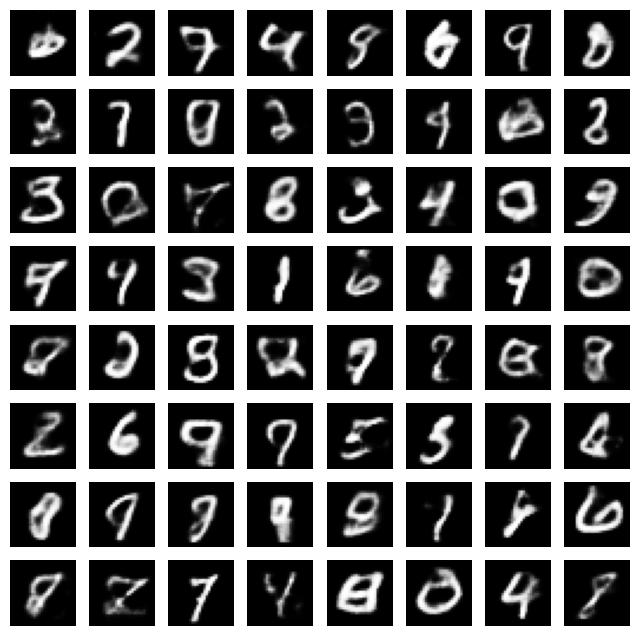

In [14]:
# Plot the generated images in an 8x8 grid
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(sample[i][0], cmap='gray')
    plt.axis('off')
plt.show()